In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from datetime import timedelta
import math
%matplotlib inline  

the details of the formulas used to build the getReputationFactor function are available in the following folder: "OpenLV - General\03 - Work\04 - Writing"

In [2]:
#df contains the actual load and the predicted load data at 30min resolution

def getReputationFactor(df, U=1.05, D=0.1, init_peak=0, peak_factor=0.9, Rmod_init=0.1):
    
      
    df["P_error"] = (df["Prediction week-1"]-df["Actual"]).abs()
    
    # Init the value of Peak with a fix value or with the first value of P-error 
    if init_peak == 0:
        df["Peak"] = df.loc[:,"P_error"][0]
    else:
        df["Peak"] = init_peak 
        
    df["Rmod"] = Rmod_init #Init the reputation factor
        
    for hh in data.iloc[1:].index: #range(1, df.shape[0],1):
        df.loc[hh, "Peak"] = df.loc[hh-1, "Peak"]*peak_factor
        
        if df.loc[hh,"P_error"] > df.loc[hh, "Peak"]:
            df.loc[hh, "Peak"]=df.loc[hh, "Peak"]
        
        if df.loc[hh, "Peak"] == 0:
            df.loc[hh, "Peak"] = 1
        
        df.loc[hh, "Rmod"] = (df.loc[hh-1, "Rmod"])*(U-D*df.loc[hh, "P_error"]/df.loc[hh, "Peak"])
        if df.loc[hh, "Rmod"] > 1:
            df.loc[hh, "Rmod"] = 1
        elif df.loc[hh, "Rmod"] < 0.1:
            df.loc[hh, "Rmod"] = 0.1

In [28]:
#df contains the actual load and the predicted load data at 30min resolution

def getReputationFactor2(df, U=1.05, D=0.1, init_peak=0, peak_factor=0.9, Rmod_init=0.1):
    
    prediction_columns = [x for x in data.columns if "Prediction" in x]
    
    df["P_error"] = 0
    
    for col in prediction_columns:
        index = col.split('-')[1]
        df["P_error "+index] = (df[col]-df["Actual"]).abs()
        df["P_error"] = df["P_error"]+df["P_error "+index]
    
      
    df["P_error"] = df["P_error"]/len(prediction_columns)
    
    # Init the value of Peak with a fix value or with the first value of P-error 
    if init_peak == 0:
        df["Peak"] = df.loc[:,"P_error"][0]
    else:
        df["Peak"] = init_peak 
        
    df["Rmod"] = Rmod_init #Init the reputation factor
        
    for hh in data.iloc[1:].index: #for each half-hour, we compute the reputation factor
        df.loc[hh, "Peak"] = df.loc[hh-1, "Peak"]*peak_factor
        
        if df.loc[hh,"P_error"] > df.loc[hh, "Peak"]:
            df.loc[hh, "Peak"]=df.loc[hh, "Peak"]
        
        if df.loc[hh, "Peak"] == 0:
            df.loc[hh, "Peak"] = 1
        
        df.loc[hh, "Rmod"] = (df.loc[hh-1, "Rmod"])*(U-D*df.loc[hh, "P_error"]/df.loc[hh, "Peak"])
        if df.loc[hh, "Rmod"] > 1:
            df.loc[hh, "Rmod"] = 1
        elif df.loc[hh, "Rmod"] < 0.1:
            df.loc[hh, "Rmod"] = 0.1

In [3]:
def createCurves(actual_consumption=5, number_of_predictions=3, RMSE=1, power=1):
    
    index = pd.DatetimeIndex(start="01/01/2018", end="31/01/2018 23:30", freq='30min')
    dataset = pd.DataFrame(index=index)
    dataset["Actual"]=actual_consumption
    
    for count in range(1, number_of_predictions+1, 1):
        dataset["Prediction week-"+str(count)]=dataset["Actual"]+(RMSE*count)**power

#     fig, ax = plt.subplots(figsize=(12, 5))
#     dataset.plot(ax=ax)
    return dataset

In [4]:
def displayCurves(df, columns):
    fig, ax = plt.subplots(figsize=(12, 5))

    ax2=ax.twinx()
    df[columns].plot(ax=ax)
    df["Rmod"].plot(ax=ax2, color='red')

    ax.margins(0,None)
    ax2.margins(0,None)
    ax.set_ylabel("Load [MW]")
    ax2.set_ylabel("Reputation", color='red')

    ax2.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
    ax2.set_ylim(0, 1.1)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines= lines+lines2
    labels=labels+labels2
    lgd = ax.legend(lines, labels, title="Legend", bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)

In [5]:
def getMetrics(df):
    
    #Number of hours passed between Rmod min and max 
    time_difference = df.loc[df["Rmod"]==df["Rmod"].min(),:].index-df.loc[df["Rmod"]==df["Rmod"].max(),:].index[0]
    nb_hours=np.absolute(time_difference.total_seconds()[0])/3600
    print("Number of hours passed between Rmod min and max: ", nb_hours)
    
    #to be completed with other metrics
    

## 1. Recovery time - how quickly a low reputation recovers on good performance
in this scenario, we are looking to set the reputation factor to its lowest value at the beginning and look in how much time, it gets to the top value

Number of hours passed between Rmod min and max:  150.0


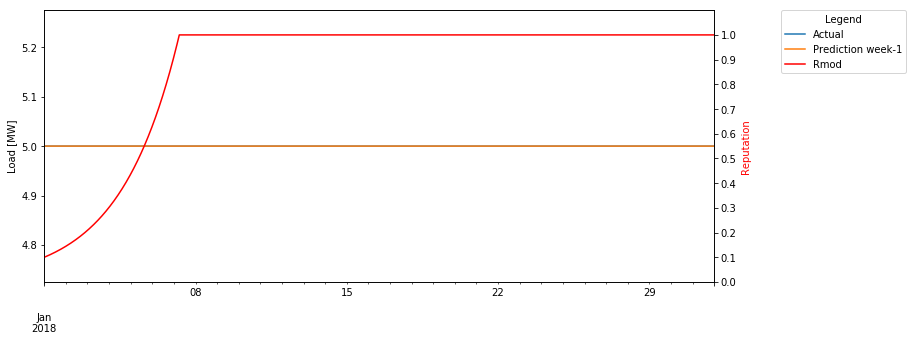

In [41]:
data = createCurves(RMSE=0, number_of_predictions=1)
columns_ax = data.columns
getReputationFactor(data, U=1.0077048141361042, D=0.4, init_peak=1, peak_factor=0.9, Rmod_init=0.1)
displayCurves(data, columns_ax)
getMetrics(data)

In [ ]:
nb_hours=150 
U= np.exp(math.log(1/0.1)/(nb_hours*2))# based on geometric progression formula
U

In [40]:
# D ? 

1.0077048141361042

## 2. Loss of reputation time – how quickly reputation is lost on poor performance
similar to previous scenario but in the other way. Reputation factor is set to its highest value and we look at how fast it decreases when predictions are bad. Two scenarios: RMSE=1 and RMSE=5 to show the impact of the magnitude of bad predictions on the drop of the reputation factor.

Number of hours passed between Rmod min and max:  17.000000000000004


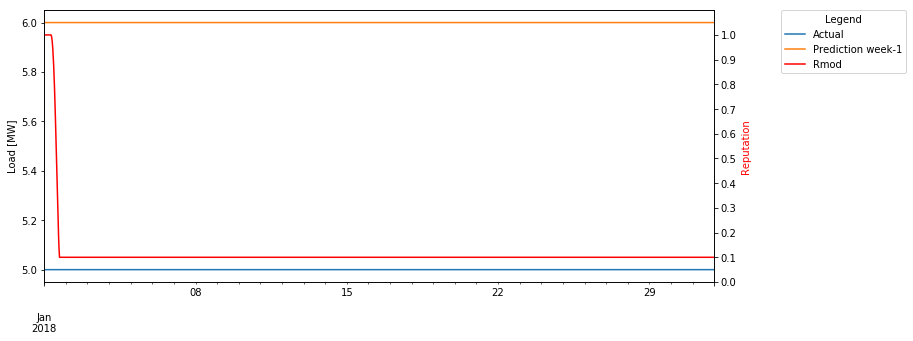

In [7]:
data = createCurves(RMSE=1, number_of_predictions=1)
columns_ax = data.columns
getReputationFactor(data, U=1.05, D=0.01, init_peak=0, peak_factor=0.9, Rmod_init=1)
displayCurves(data, columns_ax)
getMetrics(data)

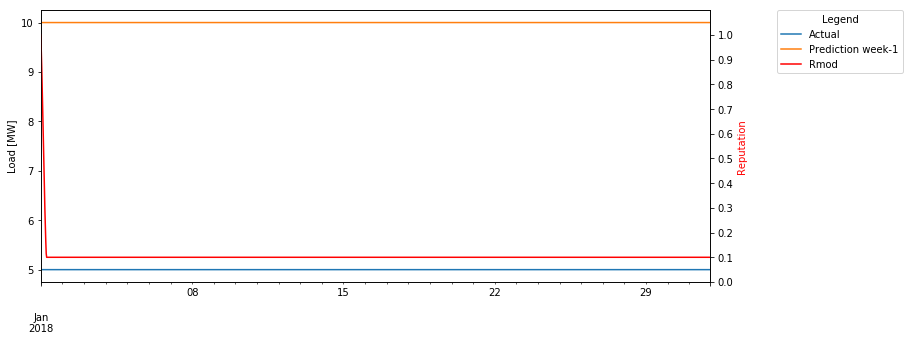

In [8]:
data = createCurves(RMSE=5, number_of_predictions=1)
columns_ax = data.columns
getReputationFactor(data, U=1.05, D=0.1, init_peak=0, peak_factor=0.9, Rmod_init=1)
displayCurves(data, columns_ax)

## 3. helpfulSensitivity, how sensitive to magnitude of mis-prediction

In [9]:
national_data = createCurves(actual_consumption=1000, RMSE=-100, number_of_predictions=1)
national_data.columns = ["National "+x for x in national_data.columns]
data = createCurves(RMSE=1, number_of_predictions=1)
fulldata=pd.concat([national_data,data], axis=1)

## 4. unhelpfulSensitivity, how sensitive to magnitude of mis-prediction

In [10]:
national_data = createCurves(actual_consumption=100, RMSE=10, number_of_predictions=1)
national_data.columns = ["National "+x for x in national_data.columns]
data = createCurves(RMSE=1, number_of_predictions=1)
fulldata=pd.concat([national_data,data], axis=1)

## 5. Comparison of the impacts of the accuracy of past predictions on the reputations factors

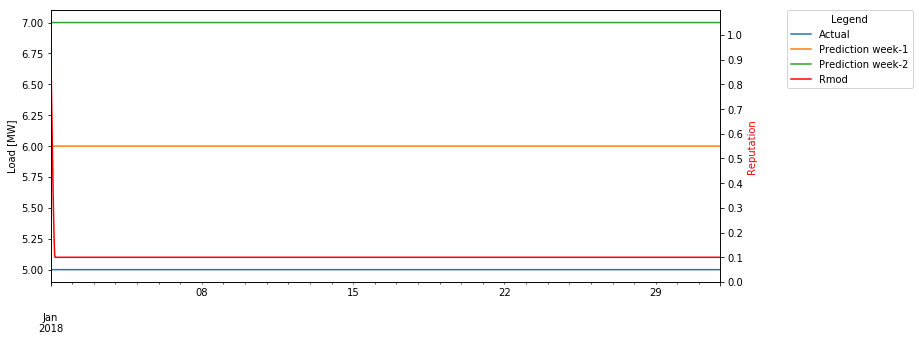

In [29]:
# Predictions are getting more accurate are we get close to the date
data = createCurves(number_of_predictions=2)
columns_ax = data.columns
getReputationFactor2(data, U=1.05, D=0.1, init_peak=1, peak_factor=0.9, Rmod_init=1)
displayCurves(data, columns_ax)

In [12]:
# Same as above but the RMSEs of the oldest predictions were worst
data = createCurves(power=2, number_of_predictions=2)

## 6. Comparison of the impacts of the consumption on the reputations factor? the reward? 
the average consumption of the meter influence the reward. A consumer with high average consumption should get more reward than a consumer with a lower average consumption when both have identitical reputation factor. 

In [13]:
data = createCurves(number_of_predictions=2)

In [14]:
# The magnitude of the consumption is ten fold, how does it affect the reputation factor? the reward?
# the RMSE stay the same
data = createCurves(actual_consumption=50, number_of_predictions=2)

In [15]:
# Same as above
# but the RMSE is ten fold as well
data = createCurves(actual_consumption=50, RMSE=10, number_of_predictions=2)